# **Halo sob..., Good Luck!** 

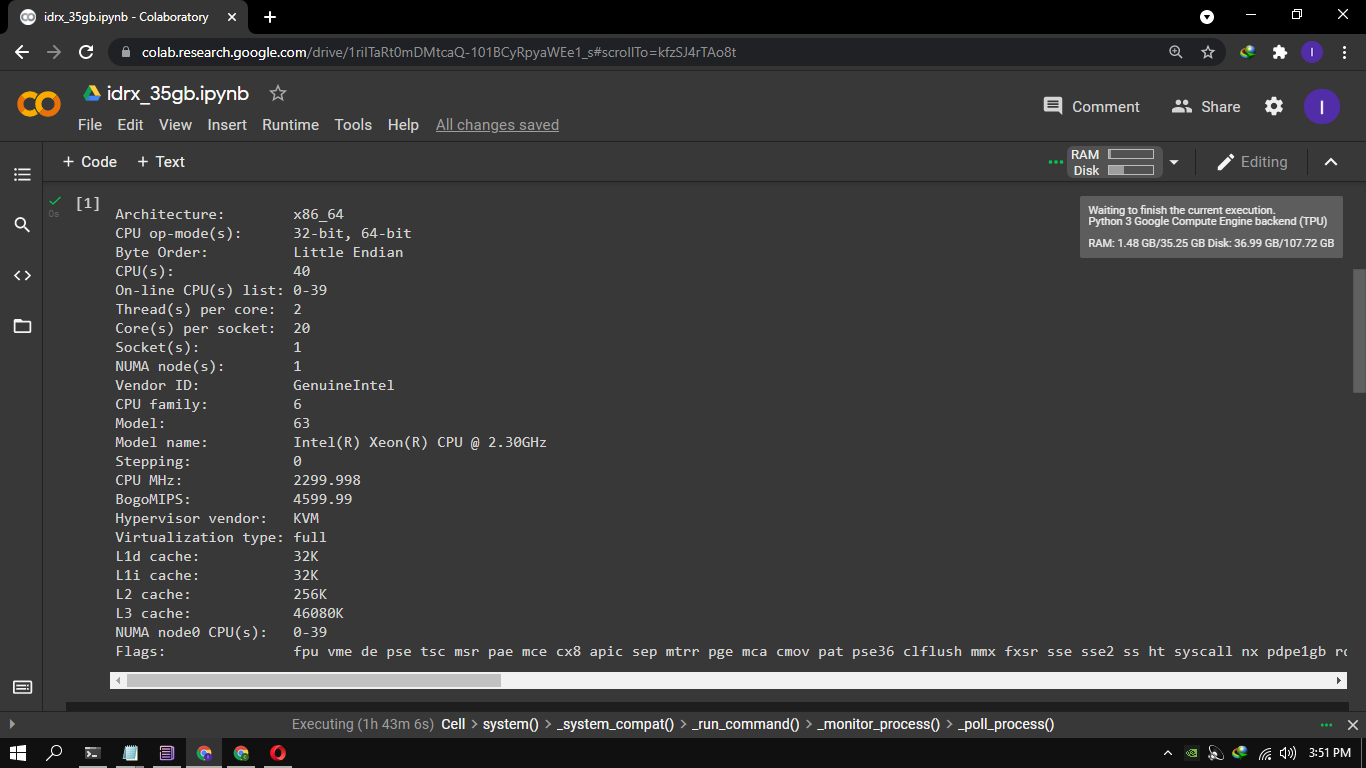

# **1. Normalnya satu kali run sudah dapat 40 CPU.**

Kalau belum dapat :

*klik Runtime - Manage sessions - Terminate (semua session) - Close popup - Refresh tab browser - Klik run lagi.*

Kalau 3 kali belum dapat, force close browser, biarkan dulu kurang lebih 10-20 menit atau buka browser baru dengan akun gmail lainnya.

*Minimal satu akun jeda 24 jam setelah running TPU or GPU.*

Kalau sudah dapat 40 CPU lanjut ke installing ssh.

In [ ]:
#@title <--  Klik run & tunggu hasilnya seperti gambar diatas
!lscpu 

-

-

# **2. Input Password Akun Ngrok & AuthToken Ngrok kalian dibawah.**

Untuk user_name biarkan saja, isi hanya pasword dan token. Lalu klik run - setelah keluar hasilnya copy hasil host, lalu paste di terminal or termux etc milik kalian. Klik enter, lalu ketik 'yes' dan enter, selanjutnya input password ngrok, lalu klik enter.

*saat input password memang tidak terlihat. Jika sudah ada tanda ' ~# ' berarti sudah sukses tersambung.*

lanjut ke step 3.

In [ ]:
import apt, apt.debfile
import pathlib, stat, shutil, urllib.request, subprocess, getpass, time, tempfile
import secrets, json, re
import IPython.utils.io
import ipywidgets
import socket
import os
from IPython.display import clear_output

class _NoteProgress(apt.progress.base.InstallProgress, apt.progress.base.AcquireProgress, apt.progress.base.OpProgress):
  def __init__(self):
    apt.progress.base.InstallProgress.__init__(self)
    self._label = ipywidgets.Label()
    display(self._label)
    self._float_progress = ipywidgets.FloatProgress(min = 0.0, max = 1.0, layout = {'border':'1px solid #118800'})
    display(self._float_progress)

  def close(self):
    self._float_progress.close()
    self._label.close()

  def fetch(self, item):
    self._label.value = "fetch: " + item.shortdesc

  def pulse(self, owner):
    self._float_progress.value = self.current_items / self.total_items
    return True

  def status_change(self, pkg, percent, status):
    self._label.value = "%s: %s" % (pkg, status)
    self._float_progress.value = percent / 100.0

  def update(self, percent=None):
    self._float_progress.value = self.percent / 100.0
    self._label.value = self.op + ": " + self.subop

  def done(self, item=None):
    pass

class _MyApt:
  def __init__(self):
    self._progress = _NoteProgress()
    self._cache = apt.Cache(self._progress)

  def close(self):
    self._cache.close()
    self._cache = None
    self._progress.close()
    self._progress = None

  def update_upgrade(self):
    self._cache.update()
    self._cache.open(None)
    self._cache.upgrade()

  def commit(self):
    self._cache.commit(self._progress, self._progress)
    self._cache.clear()

  def installPkg(self, *args):
    for name in args:
      pkg = self._cache[name]
      if pkg.is_installed:
        print(f"{name} is already installed")
      else:
        pkg.mark_install()

  def installDebPackage(self, name):
    apt.debfile.DebPackage(name, self._cache).install()

  def deleteInstalledPkg(self, *args):
    for pkg in self._cache:
      if pkg.is_installed:
        for name in args:
          if pkg.name.startswith(name):
            pkg.mark_delete()

def _download(url, path):
  try:
    with urllib.request.urlopen(url) as response:
      with open(path, 'wb') as outfile:
        shutil.copyfileobj(response, outfile)
  except:
    print("Failed to download ", url)
    raise

  return True

def _setupssh():
  user_name = "root" #@param {type:"string"}
  subprocess.run(["useradd", "-s", "/bin/bash", "-m", user_name])
  subprocess.run(["adduser", user_name, "sudo"], check = True)
  clear_output()

  ngrok_password = "" #@param {type:"string"}
  subprocess.run(["chpasswd"], input = f"{user_name}:{ngrok_password}", universal_newlines = True)
  clear_output()

  ngrok_token = "" #@param {type:"string"}

  ngrok_region = "us"

  #SSH Dropbear
  my_apt = _MyApt()
  my_apt.installPkg("dropbear")
  my_apt.commit()
  my_apt.close()

  f = open("../etc/default/dropbear", "w")
  f.write("""# the TCP port that Dropbear listens on
DROPBEAR_PORT=443

# any additional arguments for Dropbear
DROPBEAR_EXTRA_ARGS=

# specify an optional banner file containing a message to be
# sent to clients before they connect, such as "/etc/issue.net"
DROPBEAR_BANNER=""

# RSA hostkey file (default: /etc/dropbear/dropbear_rsa_host_key)
#DROPBEAR_RSAKEY="/etc/dropbear/dropbear_rsa_host_key"

# DSS hostkey file (default: /etc/dropbear/dropbear_dss_host_key)
#DROPBEAR_DSSKEY="/etc/dropbear/dropbear_dss_host_key"

# ECDSA hostkey file (default: /etc/dropbear/dropbear_ecdsa_host_key)
#DROPBEAR_ECDSAKEY="/etc/dropbear/dropbear_ecdsa_host_key"

# Receive window size - this is a tradeoff between memory and
# network performance
DROPBEAR_RECEIVE_WINDOW=65536
""")
  f.close()

  subprocess.run(["service", "dropbear", "restart"])

  root_password = ngrok_password
  subprocess.run(["chpasswd"], input = f"root:{root_password}", universal_newlines = True)

  if not os.path.exists('ngrok.zip'):
    _download("https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip", "ngrok.zip")
    shutil.unpack_archive("ngrok.zip")
    pathlib.Path("ngrok").chmod(stat.S_IXUSR)

  subprocess.run(["./ngrok", "authtoken", ngrok_token])
  ngrok_proc = subprocess.Popen(["./ngrok", "tcp", "-region", ngrok_region, "443"])
  time.sleep(2)

  with urllib.request.urlopen("http://localhost:4040/api/tunnels") as response:
    url = json.load(response)['tunnels'][0]['public_url']
    m = re.match("tcp://(.+):(\d+)", url)

  hostname = m.group(1)
  port = m.group(2)
  
  msg = ""
  msg += "="*48 + "\n"
  msg += "Command to connect to the ssh server:\n"
  msg += f"ssh -p {port} {user_name}@{socket.gethostbyname(hostname)}\n"
  msg += "="*48 + "\n"
  msg += "SSH Login:\n"
  msg += f"host          : ssh -p {port} {user_name}@{socket.gethostbyname(hostname)}\n"
  msg += f"Username      : {user_name}\n"
  msg += f"Password      : {ngrok_password}\n"
  msg += "="*48 + "\n"
  return msg

def startColab():
  msg = _setupssh()
  print(msg)

startColab()

-

-

# **3. Klik run dibawah.**

Lalu klik tanda panah kecil di kanan atas disamping kanan RAM Disk - klik 'Focus the last run cell'

In [ ]:
#@title <---  Klik run
while True:pass
time.sleep(9223372036.854775)
print ('Congratulation!!')

-

-

# **Done !!**

*Biasanya akan muncul popup ketika baru running disekitar menit ke 2 s/d 4*

*klik segera agar kalian tidak dikira robot.*

# **And finally... Selamat Menyangkul di TPU !!**

-

-

A. Jika runtime terputus setelah running kurang lebih 2,5 s/d 4,5 jam, langsung
klik 'Reconnect' di kanan atas.

* *Tunggu sampai terlihat 'RAM Disk'. Pastikan kalian masih connected di 40 CPU / 35Gb RAM.*


B.  Jika sukses masih terhubung di 40 CPU, buka terminal kalian yang sebelumnya tersambung & sedang mining. Lalu tunggu sampai koneksinya terputus *(biasanya delay beberapa menit).* Tapi jika koneksinya masih berjalan terus, berarti kalian sudah sukses menyambungkan runtime-nya lagi.

* *Jika ternyata tidak dapat 40 CPU lakukan lagi langkah nomor 1 diatas. Sampai tiga kali belum dapat, istirahat dulu kurang lebih 10-20 menit. Langkah ini meminimalisir keluarnya info popup 'Backend'.*


C. Jika koneksi di terminal akhirnya terputus & mining sudah terhenti, langkah selanjutnya klik run di langkah nomor 2 dan tunggu hasilnya.

D. Setelah itu sambungkan lagi seperti biasa ke terminal favorit milik kalian.

E. Lakukan langkah nomor 3 dan lanjutkan mining.

Done again !!





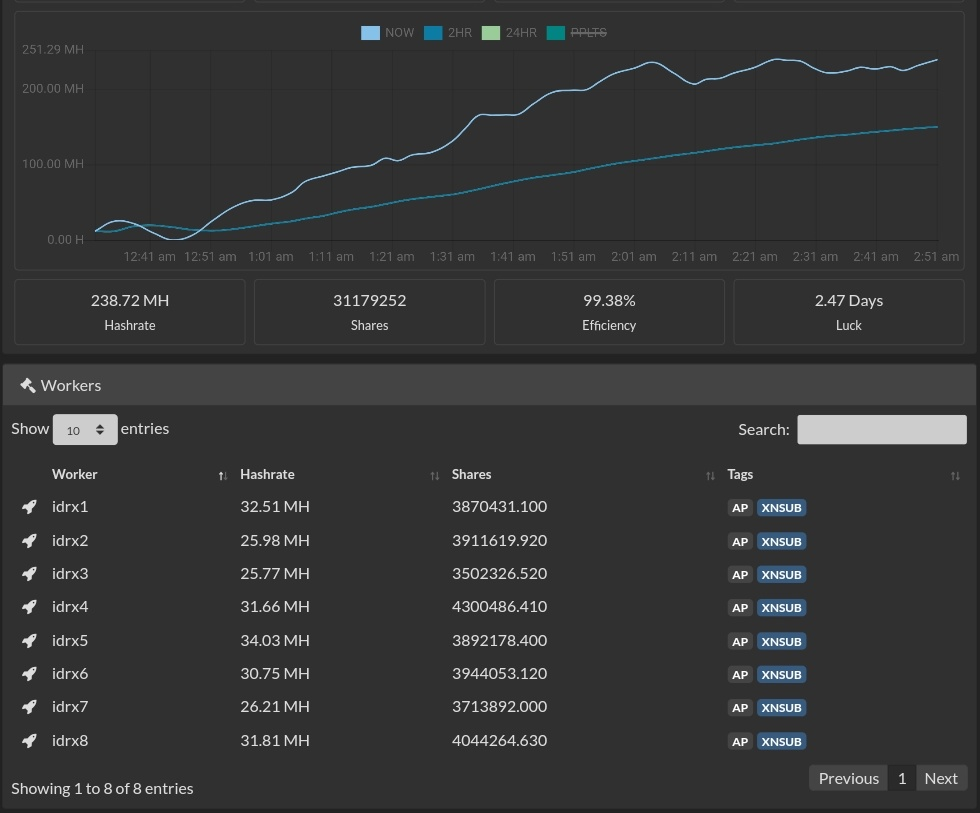

https://t.me/idrx_0